In [ ]:
!pip install ultralytics==8.0.196

In [6]:
# !pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="FCU93BcxuehxfGxgw9Gq")
project = rf.workspace("roboflow-universe-projects").project("license-plate-recognition-rxg4e")
version = project.version(4)
dataset = version.download("yolov8")

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to License-Plate-Recognition-4 in yolov8:: 100%|██████████| 48488/48488 [09:55<00:00, 81.49it/s]


In [9]:
import os

from ultralytics import YOLO


# Load a model
model = YOLO("yolov8n.yaml")  # build a new model from scratch

# Use the model
# results = model.train(data=os.path.join(ROOT_DIR, "config.yaml"), epochs=1)  # train the model
results = model.train(data="config.yaml", epochs=1)  # train the model


                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics.nn.modules.conv.Conv             [128

In [2]:
pip install ultralytics

Note: you may need to restart the kernel to use updated packages.


In [2]:
from ultralytics import YOLO

In [3]:
# load models

model_dir = 'models/best.pt'

plates_detect_model = YOLO(model_dir)

In [22]:
# load sample
import cv2

image_path = 'sample3.png'

sample = cv2.imread(image_path)



In [23]:
# detect license plates from a picture

license_plates = plates_detect_model(sample)[0]


0: 448x640 1 plate, 74.0ms
Speed: 1.9ms preprocess, 74.0ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


In [24]:
import easyocr

def read_license_plate(license_plate_crop):
  reader = easyocr.Reader(['en'], gpu=False)
  detections = reader.readtext(license_plate_crop)

  result = ''

  for detection in detections:
    bbox, text, score = detection

    text = text.upper().replace(' ', '')
    result += text

  return result

In [25]:
import matplotlib.pyplot as plt

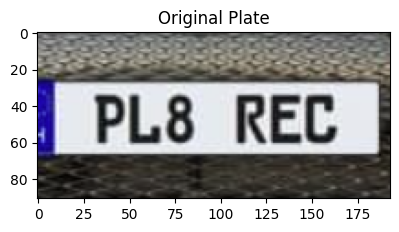

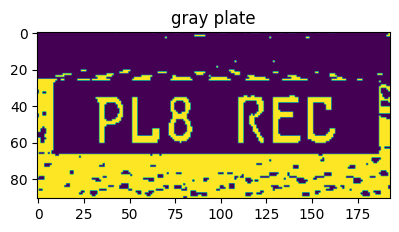

Using CPU. Note: This module is much faster with a GPU.


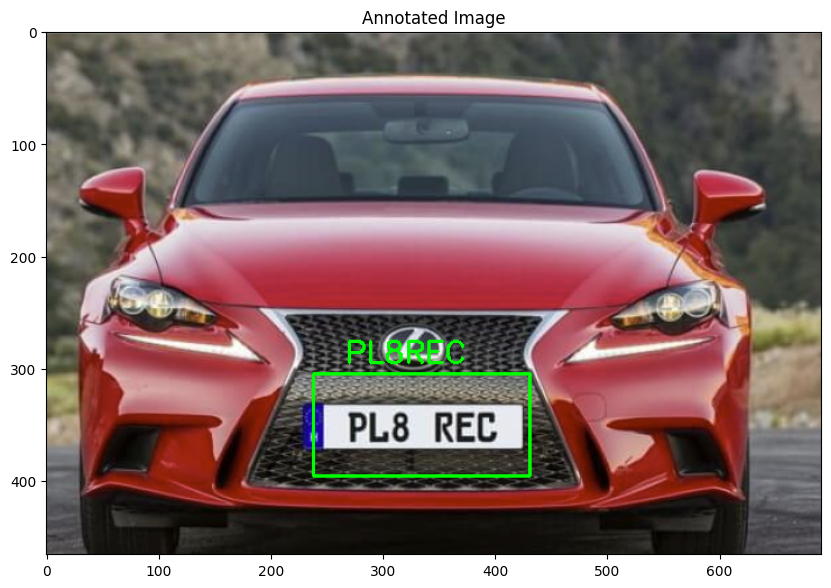

In [26]:

for license_plate in license_plates.boxes.data.tolist():
    x1, y1, x2, y2, score, class_id = license_plate

    # crop plate
    license_plate_crop = sample[int(y1): int(y2), int(x1): int(x2), :]

    
    # process license plate
    license_plate_crop_gray = cv2.cvtColor(license_plate_crop, cv2.COLOR_BGR2GRAY)
    _, license_plate_crop_thresh = cv2.threshold(license_plate_crop_gray, 64, 255, cv2.THRESH_BINARY_INV)
    
    
    license_plate_crop_rgb = cv2.cvtColor(license_plate_crop, cv2.COLOR_BGR2RGB)
    license_plate_crop_thresh_rgb = cv2.cvtColor(license_plate_crop_thresh, cv2.COLOR_GRAY2RGB)
    
    
    # plot the plate and the gray picture
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(license_plate_crop_rgb)
    plt.title('Original Plate')
    plt.show()
    
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(license_plate_crop_thresh)
    plt.title('gray plate')
    plt.show()
    

    # read license plate number
    license_plate_text = read_license_plate(license_plate_crop_thresh)

    result = sample
    # draw the line to original picture 
    cv2.rectangle(result, (int(x1), int(y1)), (int(x2), int(y2)), (0, 255, 0), 2)  # Green rectangle
    cv2.putText(result, "  " + license_plate_text, (int(x1), int(y1) - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)

    
    
    plt.figure(figsize=(10, 10))
    plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB)) 
    plt.title('Annotated Image')
    plt.show()